# Predicting Apartment Prices in Mexico City 🇲🇽

In [26]:
# Import libraries here
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from glob import glob

# Prepare Data
## Import

Write a `wrangle` function that takes the name of a CSV file as input and returns a DataFrame. The function should do the following steps:

1. Subset the data in the CSV file and return only apartments in Mexico City (`"Distrito Federal"`) that cost less than \$100,000.
2. Remove outliers by trimming the bottom and top 10\% of properties in terms of `"surface_covered_in_m2"`.
3. Create separate `"lat"` and `"lon"` columns.
4. Mexico City is divided into [15 boroughs](https://en.wikipedia.org/wiki/Boroughs_of_Mexico_City). Create a `"borough"` feature from the `"place_with_parent_names"` column.
5. Drop columns that are more than 50\% null values.
6. Drop columns containing low- or high-cardinality categorical values. 
7. Drop any columns that would constitute leakage for the target `"price_aprox_usd"`.
8. Drop any columns that would create issues of multicollinearity. 


In [27]:
# Build your `wrangle` function
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Distrito Federal", less than 100,000
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop features with high null counts
    df.drop(columns=["floor","expenses","rooms"], inplace=True)

    # Drop low and high cardinalityy categorical variables
    df.drop(columns=["operation","property_type","currency", "properati_url"], inplace=True)
    
     # Drop leaky columns
    df.drop(columns=['price','price_aprox_local_currency','price_per_m2','price_usd_per_m2'], inplace=True)
    
    df.drop(columns=['surface_total_in_m2'],inplace=True)
    
    return df

In [28]:
# Use this cell to test your wrangle function and explore the data
wrangle("/Users/macos/Documents/GitHub/wqu_projects/housing_mexico_city/mexico-city-real-estate-1.csv")

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán
...,...,...,...,...,...
4596,73761.07,85.0,19.375733,-99.139518,Benito Juárez
4597,32165.09,60.0,19.325608,-99.061120,Iztapalapa
4598,81664.04,90.0,19.441043,-99.175585,Miguel Hidalgo
4599,32770.99,50.0,19.442796,-99.154915,Cuauhtémoc


Use glob to create the list `files`. It should contain the filenames of all the Mexico City real estate CSVs in the `./data` directory, except for `mexico-city-test-features.csv`.

In [29]:
files = glob("/Users/macos/Documents/GitHub/wqu_projects/housing_mexico_city/mexico-city-real-estate-*.csv")
files

['/Users/macos/Documents/GitHub/wqu_projects/housing_mexico_city/mexico-city-real-estate-5.csv',
 '/Users/macos/Documents/GitHub/wqu_projects/housing_mexico_city/mexico-city-real-estate-4.csv',
 '/Users/macos/Documents/GitHub/wqu_projects/housing_mexico_city/mexico-city-real-estate-1.csv',
 '/Users/macos/Documents/GitHub/wqu_projects/housing_mexico_city/mexico-city-real-estate-3.csv',
 '/Users/macos/Documents/GitHub/wqu_projects/housing_mexico_city/mexico-city-real-estate-2.csv']

In [30]:
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)

In [31]:
df = pd.concat(frames, ignore_index = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,82737.39,75.0,19.362690,-99.150565,Benito Juárez
1,72197.60,62.0,19.291345,-99.124312,Tlalpan
2,44277.72,85.0,19.354987,-99.061709,Iztapalapa
3,60589.45,52.0,19.469681,-99.086136,Gustavo A. Madero
4,47429.08,53.0,19.443592,-99.121407,Venustiano Carranza


## Explore
Create a histogram showing the distribution of apartment prices (`"price_aprox_usd"`) in `df`. Be sure to label the x-axis `"Price [$]"`, the y-axis `"Count"`, and give it the title `"Distribution of Apartment Prices"`. Use Matplotlib (`plt`).

Text(0.5, 1.0, 'Distribution of Apartment Prices')

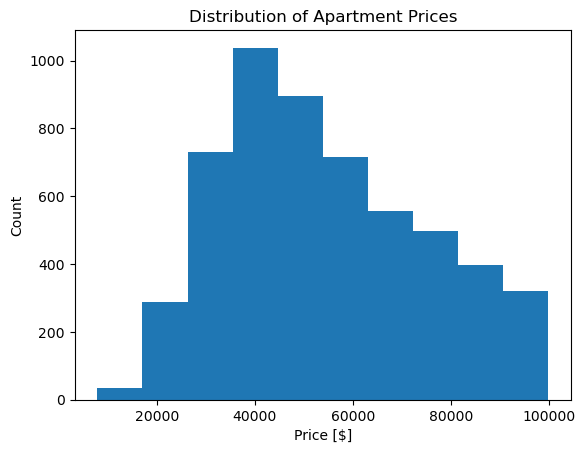

In [32]:
# Build histogram
plt.hist(df["price_aprox_usd"])


# Label axes

plt.xlabel("Price [$]")
plt.ylabel("Count")
# Add title
plt.title("Distribution of Apartment Prices")



Create a scatter plot that shows apartment price (`"price_aprox_usd"`) as a function of apartment size (`"surface_covered_in_m2"`). Be sure to label your x-axis `"Area [sq meters]"` and y-axis `"Price [USD]"`. Your plot should have the title `"Mexico City: Price vs. Area"`. Use Matplotlib (`plt`).

Text(0.5, 1.0, 'Mexico City: Price vs. Area')

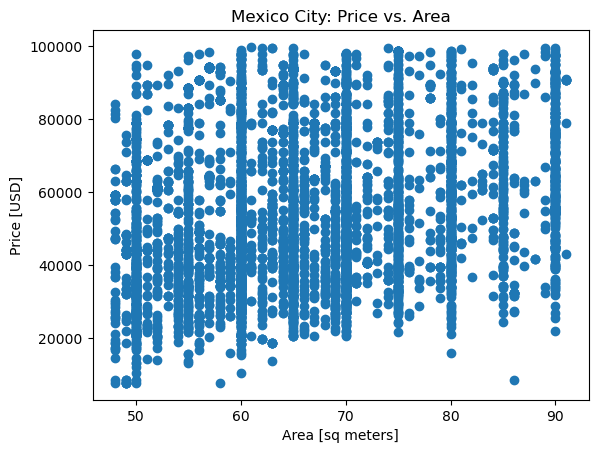

In [33]:
# Build scatter plot
plt.scatter(x=df["surface_covered_in_m2"],y=df["price_aprox_usd"])


# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")

# Add title
plt.title("Mexico City: Price vs. Area")

## Split
Create feature matrix `X_train` and target vector `y_train`. Our target is `"price_aprox_usd"`. Our features should be all the columns that remain in the DataFrame cleaned above.

In [34]:
# Split data into feature matrix `X_train` and target vector `y_train`.
target = "price_aprox_usd"
features = ["surface_covered_in_m2","lat","lon","borough"]
X_train = df[features]
y_train = df[target]

# Build Model

## Base Line
Calculate the baseline mean absolute error for the model.

In [35]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


## Iterate
Create a pipeline named `model` that contains all the transformers necessary for this dataset and one of the predictors we've used during this project. Then fit the model to the training data.

In [38]:
# Build Model
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401

model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    Ridge()
)

model.fit(X_train, y_train)
# Fit model


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate
Read the CSV file `mexico-city-test-features.csv` into the DataFrame `X_test`.

In [39]:
X_test = pd.read_csv("/Users/macos/Documents/GitHub/wqu_projects/housing_mexico_city/mexico-city-test-features.csv")
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60,19.493185,-99.205755,Azcapotzalco
1,55,19.307247,-99.166700,Coyoacán
2,50,19.363469,-99.010141,Iztapalapa
3,60,19.474655,-99.189277,Azcapotzalco
4,74,19.394628,-99.143842,Benito Juárez


Use the model to generate a Series of predictions for `X_test`.

In [40]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53538.366480
1    53171.988369
2    34263.884179
3    53488.425607
4    68738.924884
dtype: float64

## Communicate Results
Create a Series named `feat_imp`. The index should contain the names of all the features your model considers when making predictions; the values should be the coefficient values associated with each feature. The Series should be sorted ascending by absolute value.  

In [41]:
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names()
feat_imp= pd.Series(coefficients, index = features)
feat_imp.head()

/opt/anaconda3/lib/python3.11/site-packages/category_encoders/utils.py:379: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


surface_covered_in_m2      291.654156
lat                        478.901375
lon                      -2492.221814
borough_Benito Juárez    13778.188880
borough_Tlalpan          10319.429804
dtype: float64

Create a horizontal bar chart that shows the **10 most influential** coefficients for your model. Be sure to label your x- and y-axis `"Importance [USD]"` and `"Feature"`, respectively, and give your chart the title `"Feature Importances for Apartment Price"`. Use pandas. 

Text(0.5, 1.0, 'Feature Importance for Apartment Price')

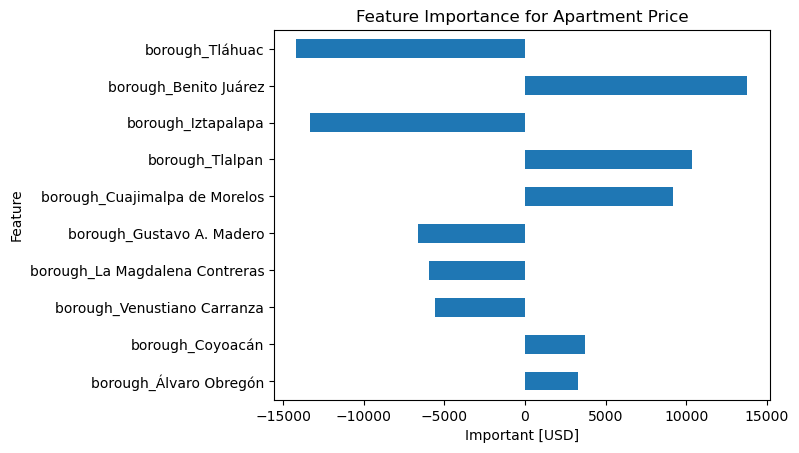

In [42]:
# Build bar chart
feat_imp.sort_values(key=abs).tail(10).plot(kind="barh")

# Label axes
plt.xlabel("Important [USD]")
plt.ylabel("Feature")
# Add title
plt.title("Feature Importance for Apartment Price")
